In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv
/kaggle/input/train-more/train_more.csv


In [2]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strat = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strat = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strat.num_replicas_in_sync)

Number of replicas: 8


### Loading the data

In [3]:
df_test=pd.read_csv('../input/contradictory-my-dear-watson/test.csv')

In [4]:
df_train=pd.read_csv('../input/contradictory-my-dear-watson/train.csv')

In [5]:
print(df_train.shape)
print(df_test.shape)

(12120, 6)
(5195, 5)


In [6]:
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [8]:
#getting value counts for each label
df_train.label.value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

In [9]:
from transformers import TFAutoModel,AutoTokenizer
import tensorflow as tf

#loading pre-trained tokens
tokenizer=AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [10]:
#train-test split
from sklearn.model_selection import train_test_split
x=df_train.iloc[:,:-1]
y=df_train.iloc[:,-1]
x_train, x_val, y_train, y_val = train_test_split( x, y, test_size=0.2, random_state=12)

In [11]:
x_train[['premise','hypothesis']].values.tolist()[0][0][0:70]

'Tourist Information offices can be very helpful.'

In [12]:
#encoding the training data with the pre-trained tokens
train_en=tokenizer.batch_encode_plus(x_train[['premise','hypothesis']].values.tolist(),
                                     padding='max_length',max_length=100,truncation=True,return_attention_mask=True)

In [13]:
train_en['input_ids'][1][1:15]

[9626,
 70,
 114977,
 55300,
 4,
 136659,
 53,
 33297,
 111,
 70,
 3622,
 41170,
 111,
 2906]

In [14]:
train_en['attention_mask'][1][1:15]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [15]:
#doing similar for validation and test
val_en=tokenizer.batch_encode_plus(x_val[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
test_en=tokenizer.batch_encode_plus(df_test[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)

In [16]:
#We have the vector form of words, let's convert into tensor data for faster processing

train_1=tf.convert_to_tensor(train_en['input_ids'],dtype=tf.int32)
train_2=tf.convert_to_tensor(train_en['attention_mask'],dtype=tf.int32)
train_input={'input_word_ids':train_1,'input_mask':train_2}

val_1=tf.convert_to_tensor(val_en['input_ids'],dtype=tf.int32)
val_2=tf.convert_to_tensor(val_en['attention_mask'],dtype=tf.int32)
val_input={'input_word_ids':val_1,'input_mask':val_2}



test_1=tf.convert_to_tensor(test_en['input_ids'],dtype=tf.int32)
test_2=tf.convert_to_tensor(test_en['attention_mask'],dtype=tf.int32)
test_input={'input_word_ids':test_1,'input_mask':test_2}

In [17]:
from keras.utils import to_categorical
#y_train=to_categorical(y_train) 
#y_val=to_categorical(y_val)

In [18]:
from tensorflow.keras import layers

In [19]:
## Model
with strat.scope():
    ids = tf.keras.Input(shape = (100,), dtype = tf.int32,name='input_word_ids') 
    mask=tf.keras.Input(shape=(100,),dtype=tf.int32,name='input_mask')    
    roberta = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    roberta = roberta([ids,mask])[0]
    #roberta.summary()
    out=layers.Flatten()(roberta)
    out=layers.BatchNormalization()(out)
    out=layers.Dense(128, activation='relu')(out)
    out=layers.Dropout(0.5)(out)
    out=layers.BatchNormalization()(out)
    out=layers.Dense(64, activation='relu')(out)
    out=layers.Dropout(0.5)(out)
    out=layers.BatchNormalization()(out)
    out=layers.Dense(3, activation='softmax')(out)
    model = tf.keras.Model(inputs = [ids,mask], outputs = out)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 102400)       0           tfxlm_roberta_model[0][0]    

In [21]:
es=tf.keras.callbacks.EarlyStopping(patience=6,restore_best_weights=True,monitor='val_accuracy',mode='max')
history=model.fit(train_input,y_train,epochs=80,batch_size=16*strat.num_replicas_in_sync,callbacks=[es],validation_data=(val_input,y_val), verbose=1)

Epoch 1/80


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


76/76 [==============================] - 276s 2s/step - loss: 0.6291 - accuracy: 0.7656 - val_loss: 0.2558 - val_accuracy: 0.9319
Epoch 2/80
76/76 [==============================] - 21s 272ms/step - loss: 0.3777 - accuracy: 0.8824 - val_loss: 0.2527 - val_accuracy: 0.9270
Epoch 3/80
76/76 [==============================] - 21s 273ms/step - loss: 0.3497 - accuracy: 0.8949 - val_loss: 0.2404 - val_accuracy: 0.9295
Epoch 4/80
76/76 [==============================] - 21s 273ms/step - loss: 0.3192 - accuracy: 0.9006 - val_loss: 0.2607 - val_accuracy: 0.9253
Epoch 5/80
76/76 [==============================] - 21s 274ms/step - loss: 0.2913 - accuracy: 0.9204 - val_loss: 0.2726 - val_accuracy: 0.9266
Epoch 6/80
76/76 [==============================] - 21s 273ms/step - loss: 0.2597 - accuracy: 0.9269 - val_loss: 0.2830 - val_accuracy: 0.9270
Epoch 7/80
76/76 [==============================] - 21s 272ms/step - loss: 0.2430 - accuracy: 0.9328 - val_loss: 0.2864 - val_accuracy: 0.9282


In [22]:
#pred=model.predict(test_input)

pred=[np.argmax(i) for i in model.predict(test_input)]
pd.DataFrame(pred).value_counts()

0    1847
1    1716
2    1632
dtype: int64

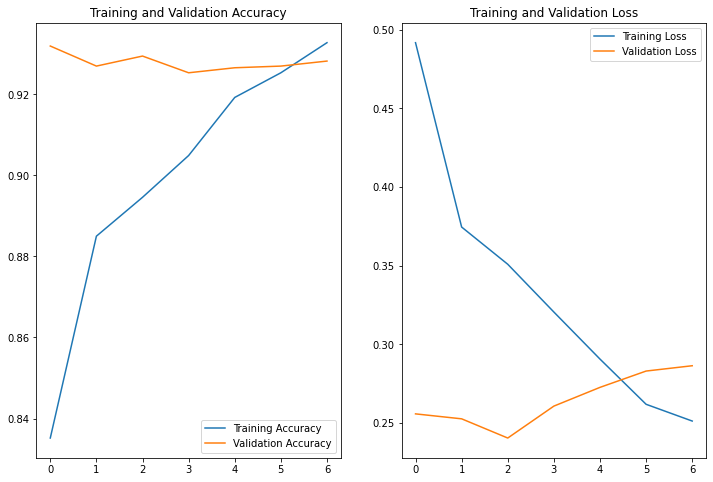

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('accuracy.png')
plt.show()


In [24]:
#y_val_n=pd.get_dummies(pd.DataFrame(y_val)).idxmax(1).to_list()
y_val_n=y_val

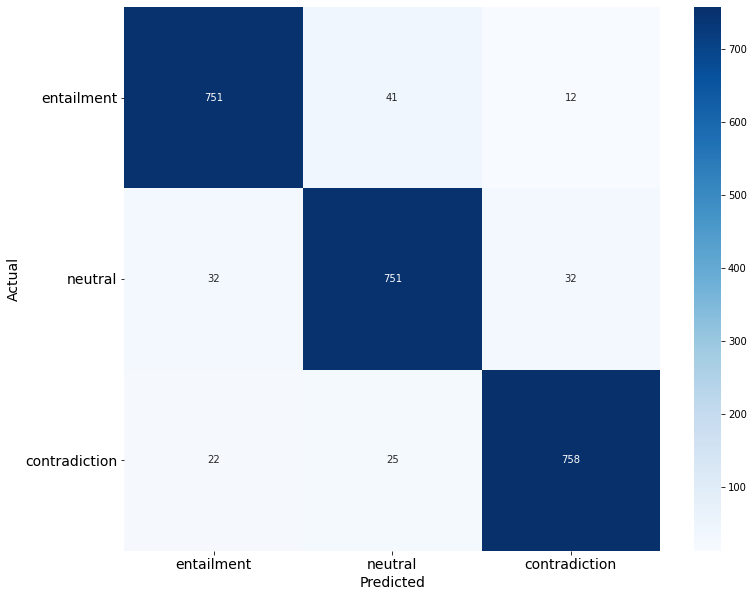

In [25]:
pred_val=[np.argmax(i) for i in model.predict(val_input)]

from sklearn.metrics import confusion_matrix
target_names=['entailment','neutral','contradiction']
cm=confusion_matrix(y_val_n, pred_val)

import seaborn as sns
plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.xaxis.set_ticklabels(target_names, rotation=0, fontsize=14)
ax.yaxis.set_ticklabels(target_names, rotation=0,fontsize=14)
ax.set_ylabel('Actual',fontsize=14)
ax.set_xlabel('Predicted',fontsize=14);
plt.savefig('cm.png')

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_val_n, pred_val, target_names=target_names))

               precision    recall  f1-score   support

   entailment       0.93      0.93      0.93       804
      neutral       0.92      0.92      0.92       815
contradiction       0.95      0.94      0.94       805

     accuracy                           0.93      2424
    macro avg       0.93      0.93      0.93      2424
 weighted avg       0.93      0.93      0.93      2424



In [27]:
#evaluate the model
eval1=model.evaluate(val_input, y_val)

76/76 [==============================] - 18s 130ms/step - loss: 0.2558 - accuracy: 0.9323


In [28]:
print('Validation accuracy:',eval1[1])

Validation accuracy: 0.9323431849479675


In [29]:
pd.DataFrame({'id':df_test.id,
              'prediction':pred}).to_csv('submission.csv',index=False)